In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time
from matplotlib import colors

if 'path' in locals(): os.chdir(path)
else: os.chdir("../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/"
path_figure3 = path_manustript + "Figure3/"
from pyMFI import MFI1D

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 22})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

grid_list = [np.linspace(0, 275, 2201), np.linspace(0, 310, 2481), np.linspace(0, 315, 2521), np.linspace(0, 330, 2641)]

The path is: /home/ucecabj/Desktop/MFI_git


#### Example analysis
Only the first 5 HILLS and colvar file of the first data-set are available on Github. The remaining data is available as already analysed force_terms (go to 2nd cell below).

100.0 %   OFE = 0.4694
100.0 %   OFE = 2.6804
100.0 %   OFE = 0.4734
100.0 %   OFE = 2.5617
100.0 %   OFE = 0.4662
100.0 %   OFE = 2.6225
100.0 %   OFE = 0.4744
100.0 %   OFE = 2.6424
100.0 %   OFE = 0.5032
100.0 %   OFE = 2.6549


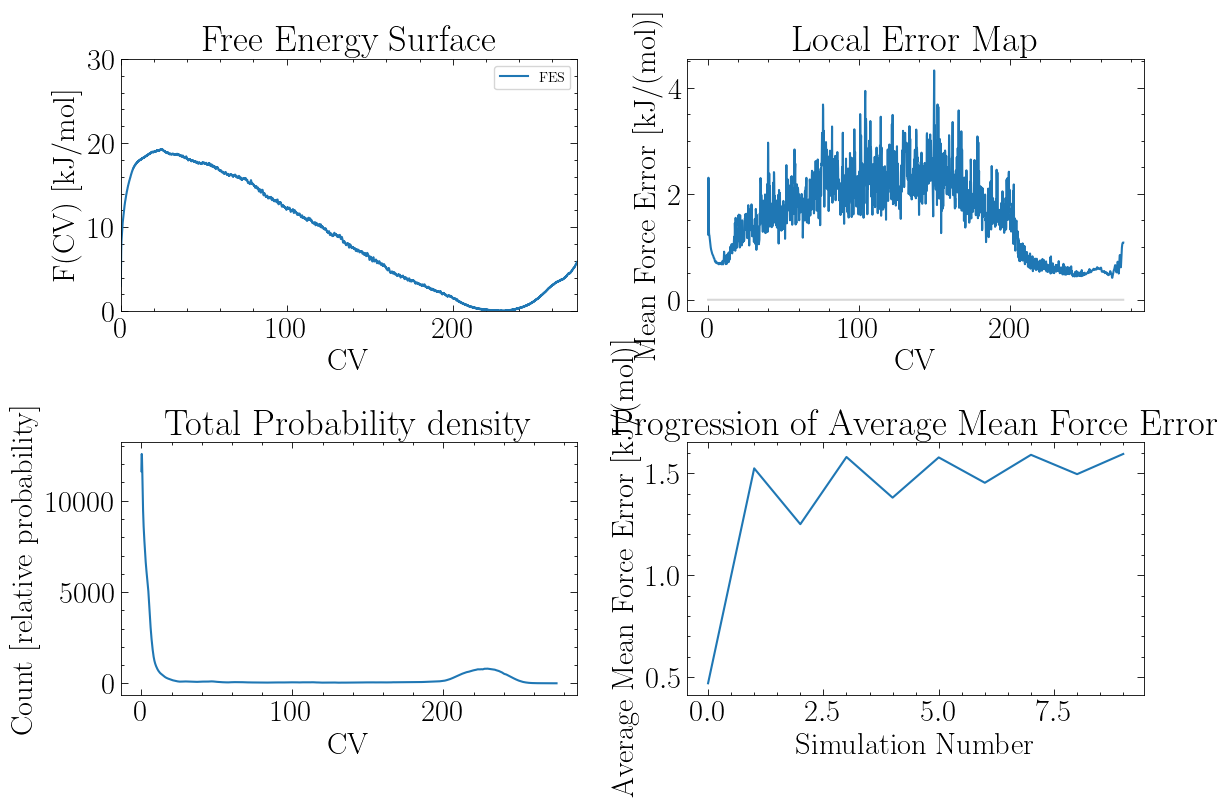

In [22]:
path_back = path + "/DATA_examples/1D_LJ_T6n55/data_backward/"
path_forw = path + "/DATA_examples/1D_LJ_T6n55/data_forward/"
path_forceterms = path + "/DATA_examples/1D_LJ_T6n55/force_terms/"
os.chdir(path + "/DATA_examples/1D_LJ_T6n55")

# Load the static bias
bias_force = MFI1D.load_pkl(path_forw + "negativebias")
all_forceterms = []

for i in range(1,6):
    
    #~~~ FORWARD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    #Read the HILLS file
    HILLS=MFI1D.load_HILLS(hills_name=path_forw + "HILLS_" + str(i))

    #Read the Colvar File
    position = MFI1D.load_position(position_name=path_forw + "COLVAR_" + str(i))

    #Compute the time-independent mean force
    results = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.5, kT = 0.6, min_grid=0, max_grid=275, nbins=2201, log_pace=len(HILLS), F_static=bias_force)
    X, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_evol, fes_error_cutoff_evol = results

    #save force terms
    all_forceterms.append([Ftot_den, Ftot_den2, Ftot, ofv_num])
    
    #~~~ BACKWARD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    # #Read the HILLS file
    HILLS=MFI1D.load_HILLS(hills_name=path_back + "HILLS_" + str(i))

    #Read the Colvar File
    position = MFI1D.load_position(position_name=path_back + "COLVAR_" + str(i))

    #Compute the time-independent mean force
    results = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.5, kT = 0.6, min_grid=0, max_grid=275, nbins=2201, log_pace=len(HILLS), F_static=np.zeros(len(X)))
    X, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_evol, fes_error_cutoff_evol = results

    #save force terms
    all_forceterms.append([Ftot_den, Ftot_den2, Ftot, ofv_num])

     
#patch all forces
Ftot_den, Ftot_den2, Ftot, ofv_num, ofe, Aofe = MFI1D.patch_forces_ofe(np.asarray(all_forceterms), ofe_progression=True)

#Integrate patched mean force
FES = MFI1D.intg_1D(Ftot, X[1]-X[0])
    
# Plot Recap
MFI1D.plot_recap(X, MFI1D.zero_to_nan(FES), MFI1D.zero_to_nan(Ftot_den), MFI1D.zero_to_nan(ofe), Aofe, range(len(Aofe)), FES_lim=30, ofe_lim = 15, error_log_scale=0)
plt.xlabel("Simulation Number"); plt.show()

#### Bootstrap and Plot (this will take a while)

In [18]:
name_list = ["55", "65", "73", "80"]
label_list = ["11.95", "14.03", "15.57", "18.86"]
grid_list = [np.linspace(0, 275, 2201), np.linspace(0, 310, 2481), np.linspace(0, 315, 2521), np.linspace(0, 330, 2641)]
FES_sd_list = []
bootstrap_sd_prog = [[], [], [], []]

n_bootstrap = 1000

for i in [0,1,2,3]:

    #load forward and backward forces
    [forceterms_forw, forceterms_back] = MFI1D.load_npy(path_figure3 + "LJ_n" + name_list[i] + "_allforces")

    #Boostrap: Start from 2 simulations and with each iteration add one more simulation.
    for j in np.arange(2,len(forceterms_forw)):
        print(i, ": dataset LJ_n" + name_list[i], "| total simulations =", j)
        [FES_avr, sd_fes, sd_fes_prog ] = MFI1D.bootstrap_forw_back(grid_list[i], np.asarray(forceterms_forw[:j,[0,2],:]), np.asarray(forceterms_back[:j,[0,2],:]), n_bootstrap=n_bootstrap, set_fes_minima="first_value")
        bootstrap_sd_prog[i].append(sd_fes_prog[-1])
    
    # remove undefined values at the end
    [x_plot, FES_plot, sd_plot] = MFI1D.remove_flat_tail(grid_list[i], FES_avr, sd_fes)
        
    # patch all forces and calculate FES_patch and ofe
    all_forces = []
    for j in range(len(forceterms_forw)): 
        all_forces.append(forceterms_back[j])
        all_forces.append(forceterms_forw[j])    
    Ftot_den, Ftot_den2, Ftot, ofv_num, ofe, Aofe = MFI1D.patch_forces_ofe(np.asarray(all_forces), ofe_progression=True, use_weighted_st_dev=False)
    FES_patch = MFI1D.intg_1D(Ftot, grid_list[i][1]-grid_list[i][0])
    
    #rename results for plotting
    if i == 0: [x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    if i == 1: [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    if i == 2: [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    if i == 3: [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3] = [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe]
    
# MFI1D.save_pkl([bootstrap_sd_prog, [x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0], [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1], [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2], [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3]], path_figure4 + "Figure4_data_err_vs_nsim.pkl")

0 : dataset LJ_n55 | total simulations = 2
Iteration: 50 - sd: 0.0
Iteration: 100 - sd: 0.0
Iteration: 150 - sd: 0.0
Iteration: 200 - sd: 0.0
Iteration: 250 - sd: 0.0
Iteration: 300 - sd: 0.0
Iteration: 350 - sd: 0.0
Iteration: 400 - sd: 0.0
Iteration: 450 - sd: 0.0
Iteration: 500 - sd: 0.0
Iteration: 550 - sd: 0.0
Iteration: 600 - sd: 0.0
Iteration: 650 - sd: 0.0
Iteration: 700 - sd: 0.0
Iteration: 750 - sd: 0.0
Iteration: 800 - sd: 0.0
Iteration: 850 - sd: 0.0
Iteration: 900 - sd: 0.0
Iteration: 950 - sd: 0.0
Iteration: 1000 - sd: 0.0
0 : dataset LJ_n55 | total simulations = 3
Iteration: 50 - sd: 0.86292
Iteration: 100 - sd: 0.90285
Iteration: 150 - sd: 0.92796
Iteration: 200 - sd: 0.90936
Iteration: 250 - sd: 0.89872
Iteration: 300 - sd: 0.90152
Iteration: 350 - sd: 0.90413
Iteration: 400 - sd: 0.91906
Iteration: 450 - sd: 0.9213
Iteration: 500 - sd: 0.91849
Iteration: 550 - sd: 0.92566
Iteration: 600 - sd: 0.93653
Iteration: 650 - sd: 0.93955
Iteration: 700 - sd: 0.93279
Iteration:

47
47
48
48


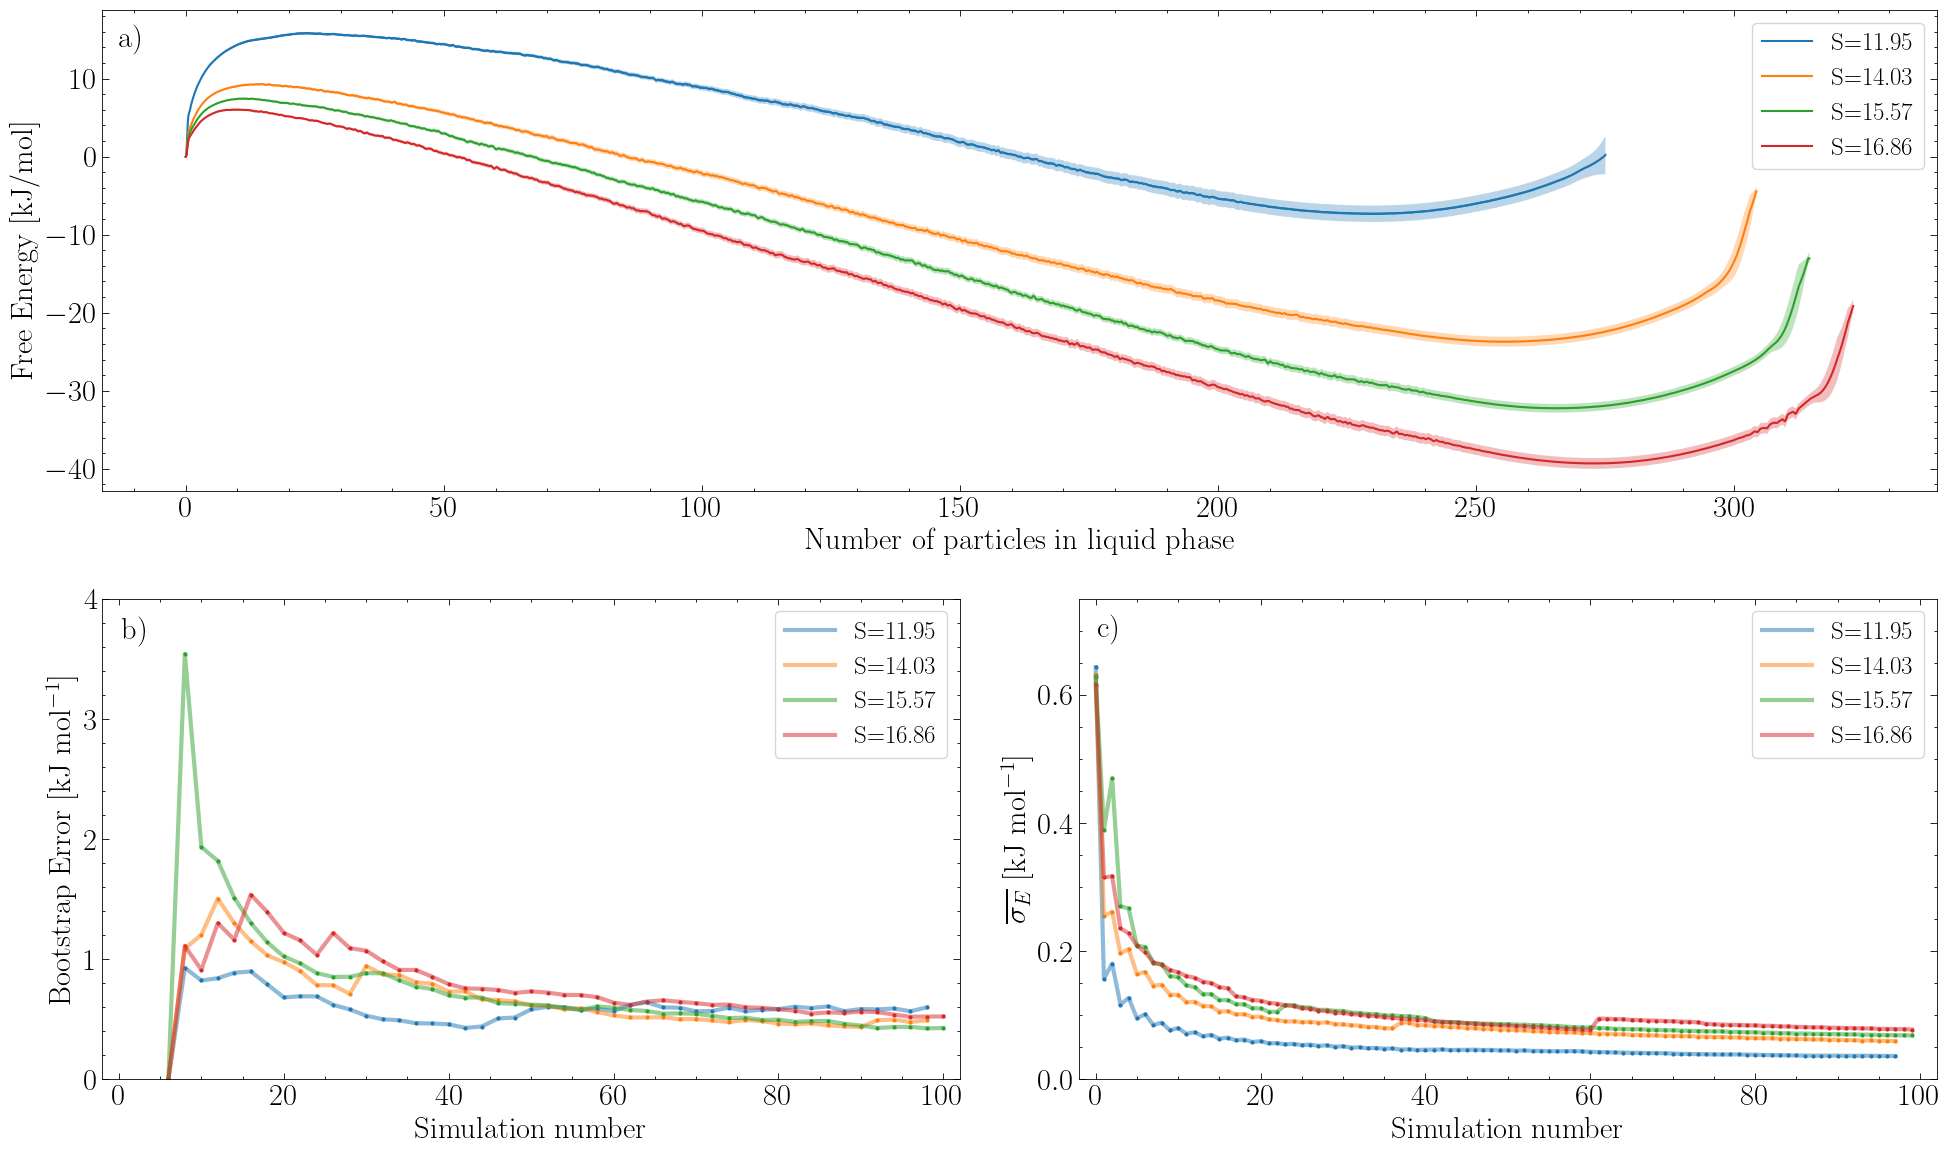

In [21]:
# data = MFI1D.load_pkl(path_figure3 + "Figure4_data_err_vs_nsim.pkl")

# [bootstrap_sd_prog, 
#  [x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0], 
#  [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1], 
#  [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2], 
#  [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3]] = data

name_list = ["55", "65", "73", "80"]
label_list = ["11.95", "14.03", "15.57", "16.86"]
n_bootstrap = 1000
plt.figure(figsize=(20,12)); 

for i in [0,1,2,3]:
    
    if i == 0: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_0, FES_0, sd_0, sd_fes_prog_0, Aofe_0]
    if i == 1: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_1, FES_1, sd_1, sd_fes_prog_1, Aofe_1]
    if i == 2: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_2, FES_2, sd_2, sd_fes_prog_2, Aofe_2]
    if i == 3: [x_plot, FES_plot, sd_plot, sd_fes_prog, Aofe] = [x_3, FES_3, sd_3, sd_fes_prog_3, Aofe_3]
    
    print(len(bootstrap_sd_prog[i]))

    plt.subplot(2,1,1)
    plt.plot(x_plot, FES_plot, label="S=" + label_list[i]);
    plt.fill_between(x_plot, FES_plot - sd_plot, FES_plot + sd_plot, alpha=0.3)

    plt.subplot(2,2,3)
    # plt.plot(range(len(sd_fes_prog)), sd_fes_prog, label="S=" + label_list[i],alpha=0.5,linewidth=3)
    plt.plot([e*2 for e in range(3, len(bootstrap_sd_prog[i])+3)], bootstrap_sd_prog[i], label="S=" + label_list[i],alpha=0.5,linewidth=3)
    plt.scatter([e*2 for e in range(3, len(bootstrap_sd_prog[i])+3)], bootstrap_sd_prog[i], s=4)
    # plt.scatter(range(len(sd_fes_prog)), sd_fes_prog, s=4)

    plt.subplot(2,2,4)
    # plt.plot(range(len(Aofe)), Aofe, label="S=" + label_list[i])
    plt.plot(range(len(Aofe)), Aofe, label="S=" + label_list[i],alpha=0.5,linewidth=3)
    plt.scatter(range(len(Aofe)), Aofe, s=4)


plt.subplot(2,1,1); plt.xlabel("Number of particles in liquid phase"), plt.ylabel("Free Energy [kJ/mol]"); plt.legend(fontsize=18); #plt.title("Free Enery Surface with Standard Deviation form Bootstraping ")
# plt.ylim(-5,20);
plt.text(-13,14, "a)")

plt.subplot(2,2,3)
plt.ylim(0,4); 
plt.xlim(-2,102)
plt.xlabel("Simulation number"), plt.ylabel("Bootstrap Error [kJ mol$^{-1}$]"); plt.legend(fontsize=18); #plt.title("Progression of Standard Deviation by Bootstrap Iteration")
plt.text(0.3, 3.66, "b)")

plt.subplot(2,2,4); 
plt.ylim(0, 0.75); 
plt.xlim(-2,102)
plt.xlabel("Simulation number"), plt.ylabel("$\overline{\sigma_E}$ [kJ mol$^{-1}$]"); plt.legend(fontsize=18); #plt.title("Progression of the Error of the Mean Force")
plt.text(0.3, 0.69, "c)")


plt.tight_layout()
plt.savefig(path_manustript + 'Figure3/Figure3_MFI.png', dpi=600, bbox_inches='tight')
plt.show()


#### Compare ofe vs aad

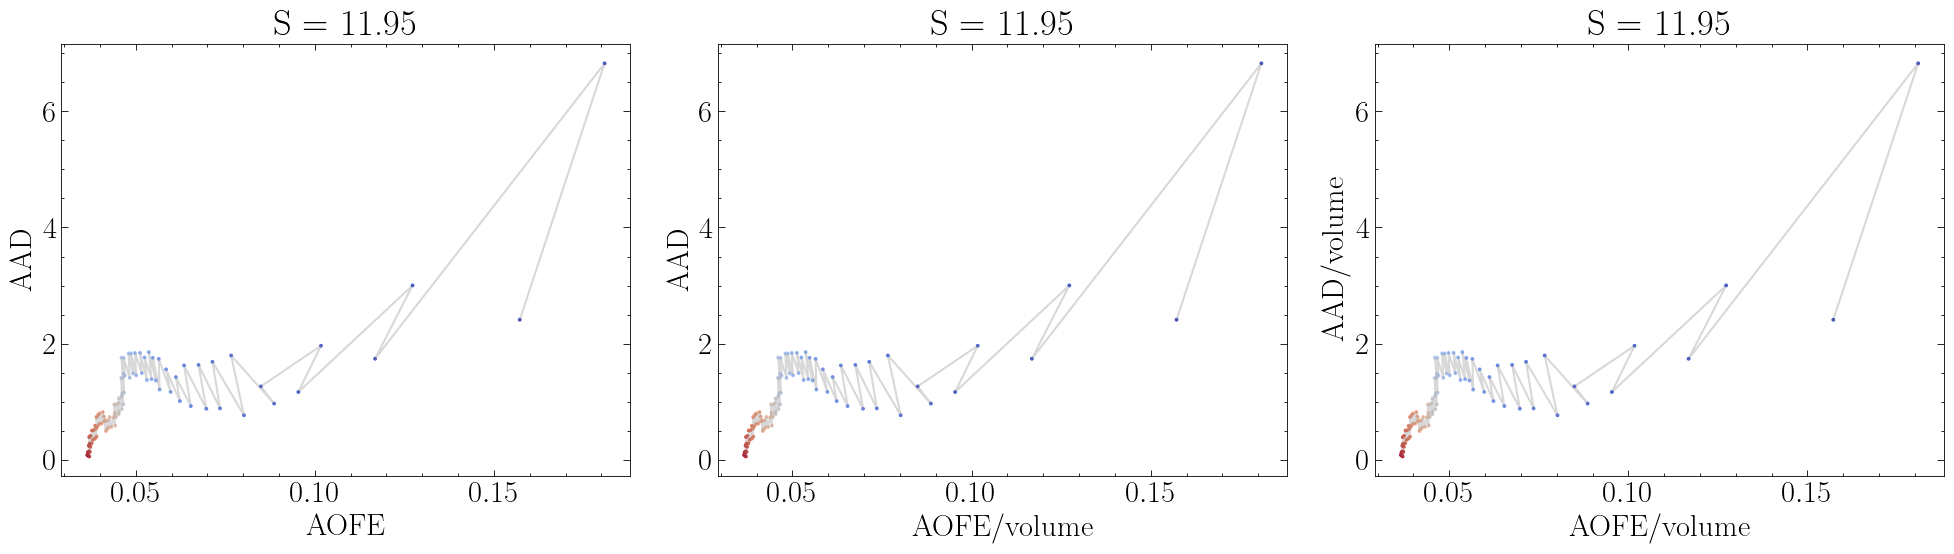

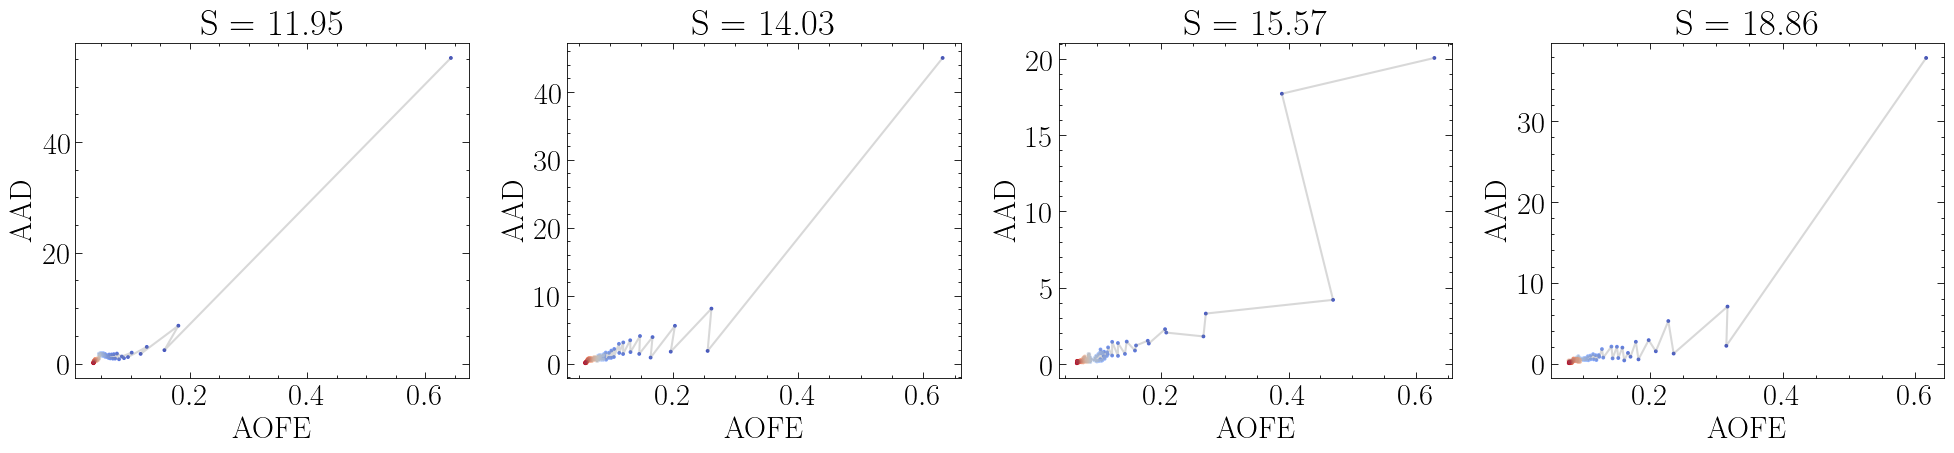

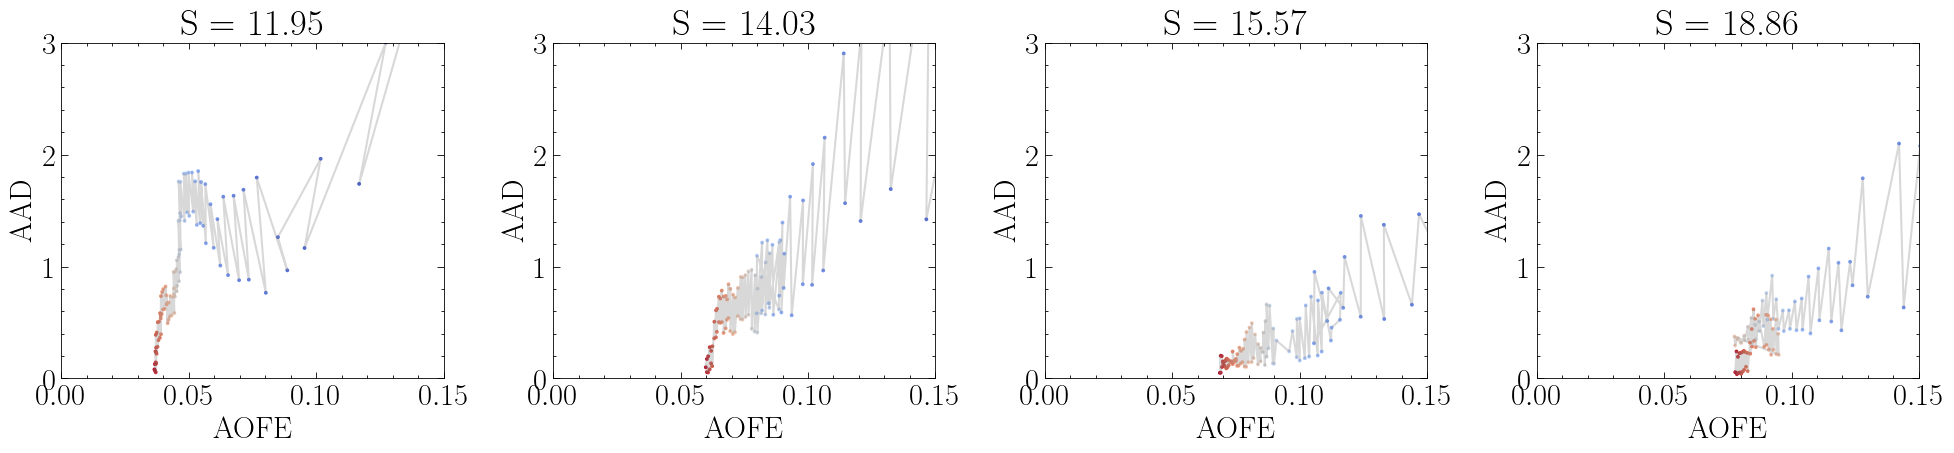

In [10]:
name_list = ["55", "65", "73", "80"]
label_list = ["11.95", "14.03", "15.57", "18.86"]
grid_list = [np.linspace(0, 275, 2201), np.linspace(0, 310, 2481), np.linspace(0, 315, 2521), np.linspace(0, 330, 2641)]
FES_sd_list = []
max_ofe = 0
min_ofe = 1
max_Aofe = 0
min_Aofe = 1

# plt.figure(figsize=(20,5))
cmap = plt.cm.get_cmap('coolwarm')

for i in [0,1,2,3]:
    #load forward and backward forces
    [forceterms_forw, forceterms_back] = MFI1D.load_npy(path_figure4 + "LJ_n" + name_list[i] + "_allforces")
    #Load fererence fes
    FES_ref = MFI1D.load_pkl(path_figure4 + "FES_avr_nb1000_T" + name_list[i])

    all_forces = []
    for j in range(len(forceterms_forw)): 
        all_forces.append(forceterms_back[j])
        all_forces.append(forceterms_forw[j])    
    PD_patch, PD2_patch, F_patch, OFV_num_patch, FES, AD, AAD, OFE, AOFE, volume = MFI1D.patch_forces_ofe_AD(np.asarray(all_forces), grid=grid_list[i], y=FES_ref, error_progression=True, use_weighted_st_dev=False, set_fes_minima="first")

    if i == 0:
        plt.figure(1,figsize=(20,6)); 
        norm = plt.Normalize(0, len(AOFE[1:])) 
        
        plt.subplot(1,3,1)
        plt.scatter(AOFE[1:], AAD[1:] ,s=3, c=range(len(AOFE[1:])), cmap=cmap, norm=norm)
        plt.plot(AOFE[1:], AAD[1:] , c="grey", alpha=0.3); 
        plt.ylabel("AAD"); plt.xlabel("AOFE"); plt.title("S = " + label_list[i])

        plt.subplot(1,3,2)
        plt.scatter(AOFE[1:]/volume[1:], AAD[1:] ,s=3, c=range(len(AOFE[1:])), cmap=cmap, norm=norm)
        plt.plot(AOFE[1:]/volume[1:], AAD[1:] , c="grey", alpha=0.3); 
        plt.ylabel("AAD"); plt.xlabel("AOFE/volume"); plt.title("S = " + label_list[i])
        
        plt.subplot(1,3,3)
        plt.scatter(AOFE[1:]/volume[1:], AAD[1:]/volume[1:] ,s=3, c=range(len(AOFE[1:])), cmap=cmap, norm=norm)
        plt.plot(AOFE[1:]/volume[1:], AAD[1:]/volume[1:] , c="grey", alpha=0.3); 
        plt.ylabel("AAD/volume"); plt.xlabel("AOFE/volume"); plt.title("S = " + label_list[i])
        plt.tight_layout(); plt.show()

    plt.figure(2,figsize=(20,5))
    plt.subplot(1,4,i+1)
    norm = plt.Normalize(0, len(AOFE)) 
    plt.scatter(AOFE, AAD ,s=3, c=range(len(AOFE)), cmap=cmap, norm=norm)
    plt.plot(AOFE, AAD , c="grey", alpha=0.3); 
    plt.ylabel("AAD"); plt.xlabel("AOFE"); plt.title("S = " + label_list[i]); plt.tight_layout()
    
    plt.figure(3,figsize=(20,5))
    plt.subplot(1,4,i+1)
    norm = plt.Normalize(0, len(AOFE)) 
    plt.scatter(AOFE, AAD ,s=3, c=range(len(AOFE)), cmap=cmap, norm=norm)
    plt.plot(AOFE, AAD , c="grey", alpha=0.3); 
    plt.ylabel("AAD"); plt.xlabel("AOFE"); plt.title("S = " + label_list[i]); plt.xlim(0,0.15); plt.ylim(0,3); plt.tight_layout()

# plt.figure(2,figsize=(20,5)); plt.tight_layout()
# plt.figure(1,figsize=(20,5)); plt.tight_layout()
plt.show()